1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [2]:
!pip install scikit-uplift
!pip install CatBoost

     |████████████████████████████████| 65.8MB 61kB/s 


In [3]:
!pip install causalml

     |████████████████████████████████| 245kB 13.1MB/s 
     |████████████████████████████████| 20.1MB 1.2MB/s 
     |████████████████████████████████| 358kB 48.7MB/s 
     |████████████████████████████████| 1.8MB 39.8MB/s 
  Created wheel for causalml: filename=causalml-0.9.0-cp36-cp36m-linux_x86_64.whl size=481148 sha256=efa312c8cb5f12545db8f86f3ab004fa7bef7697cfc0dfa7aa29b090b1b921c1
  Stored in directory: /root/.cache/pip/wheels/6d/c4/e2/451f0ebc2f9a7540256b0a705a2fd09864893131aee58d5af9
  Created wheel for shap: filename=shap-0.38.1-cp36-cp36m-linux_x86_64.whl size=489380 sha256=93763dc458ecc9eac710117ec881b2979b2cdf00baaf8ae1b5ef6d4166e541b4
  Stored in directory: /root/.cache/pip/wheels/a8/fb/e4/88012be41842b9be62ae18d82d1b1e880daf8539d1fef1fa00
Successfully built causalml shap
ERROR: tensorflow 2.4.0 has requirement numpy~=1.19.2, but you'll have numpy 1.18.5 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is in

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel, ClassTransformation, TwoModels

from catboost import CatBoostClassifier

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

### Загрузка данных

In [5]:
from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


In [6]:
TRAIN_DATASET_PATH = './data.csv'

In [7]:
df = pd.read_csv(TRAIN_DATASET_PATH)

### Анализ данных

In [8]:
df.shape

(64000, 9)

In [9]:
df.describe().T

count      mean       std      min      25%       50%  \
recency       64000.00000   5.76373   3.50759  1.00000  2.00000   6.00000   
history       64000.00000 242.08566 256.15861 29.99000 64.66000 158.11000   
used_discount 64000.00000   0.55103   0.49739  0.00000  0.00000   1.00000   
used_bogo     64000.00000   0.54972   0.49753  0.00000  0.00000   1.00000   
is_referral   64000.00000   0.50225   0.50000  0.00000  0.00000   1.00000   
conversion    64000.00000   0.14678   0.35389  0.00000  0.00000   0.00000   

                    75%        max  
recency         9.00000   12.00000  
history       325.65750 3345.93000  
used_discount   1.00000    1.00000  
used_bogo       1.00000    1.00000  
is_referral     1.00000    1.00000  
conversion      0.00000    1.00000

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [11]:
df.head(5)

recency   history  used_discount  used_bogo   zip_code  is_referral  \
0       10 142.44000              1          0  Surburban            0   
1        6 329.08000              1          1      Rural            1   
2        7 180.65000              0          1  Surburban            1   
3        9 675.83000              1          0      Rural            1   
4        2  45.34000              1          0      Urban            0   

  channel            offer  conversion  
0   Phone  Buy One Get One           0  
1     Web         No Offer           0  
2     Web  Buy One Get One           0  
3     Web         Discount           0  
4     Web  Buy One Get One           0

In [12]:
df.describe(include=['O']).T

count unique              top   freq
zip_code  64000      3        Surburban  28776
channel   64000      3              Web  28217
offer     64000      3  Buy One Get One  21387

In [13]:
df.isnull().sum()

recency          0
history          0
used_discount    0
used_bogo        0
zip_code         0
is_referral      0
channel          0
offer            0
conversion       0
dtype: int64

### Обработка данных

In [14]:
def rename_col(df):    
    df.rename(columns={'conversion': 'target', 'offer': 'treatment', 
    }, inplace=True)
    
rename_col(df)

In [15]:
df['treatment'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [16]:
df['treatment'] = df['treatment'].replace({'Buy One Get One': 1, 'Discount': 1, 'No Offer': 0})

In [17]:
df.head()

recency   history  used_discount  used_bogo   zip_code  is_referral  \
0       10 142.44000              1          0  Surburban            0   
1        6 329.08000              1          1      Rural            1   
2        7 180.65000              0          1  Surburban            1   
3        9 675.83000              1          0      Rural            1   
4        2  45.34000              1          0      Urban            0   

  channel  treatment  target  
0   Phone          1       0  
1     Web          0       0  
2     Web          1       0  
3     Web          1       0  
4     Web          1       0

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   treatment      64000 non-null  int64  
 8   target         64000 non-null  int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 4.4+ MB


### Подготовка данных

In [19]:
X = pd.get_dummies(df)
X.drop('target', axis=1, inplace=True)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Одна модель с признаком коммуникации

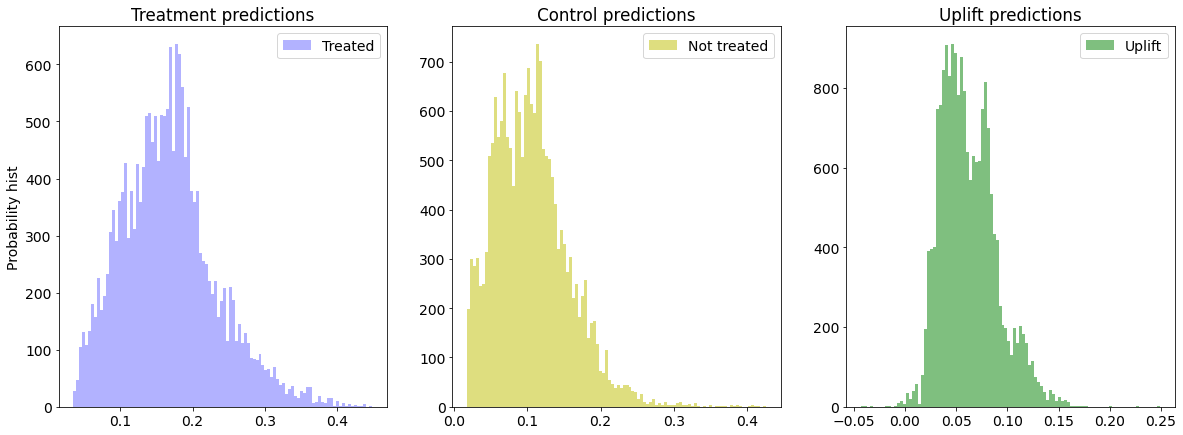

In [20]:
models_results = {
    'name': [],
    'uplift@10%': [],
    'uplift@20%': []
}

treat_train = X_train.treatment
treat_test = X_test.treatment

sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['name'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [21]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

feature_name  feature_score
0            is_referral       19.06800
1              treatment       16.27446
2                history       14.39985
3              used_bogo       11.48133
4                recency       10.72001
5          used_discount        8.86487
6         zip_code_Rural        7.28558
7          channel_Phone        4.64004
8            channel_Web        4.63789
9     zip_code_Surburban        1.49943
10        zip_code_Urban        1.12855
11  channel_Multichannel        0.00000

### Модель с трансформацией таргета

In [22]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

models_results['name'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

### Две независимые модели

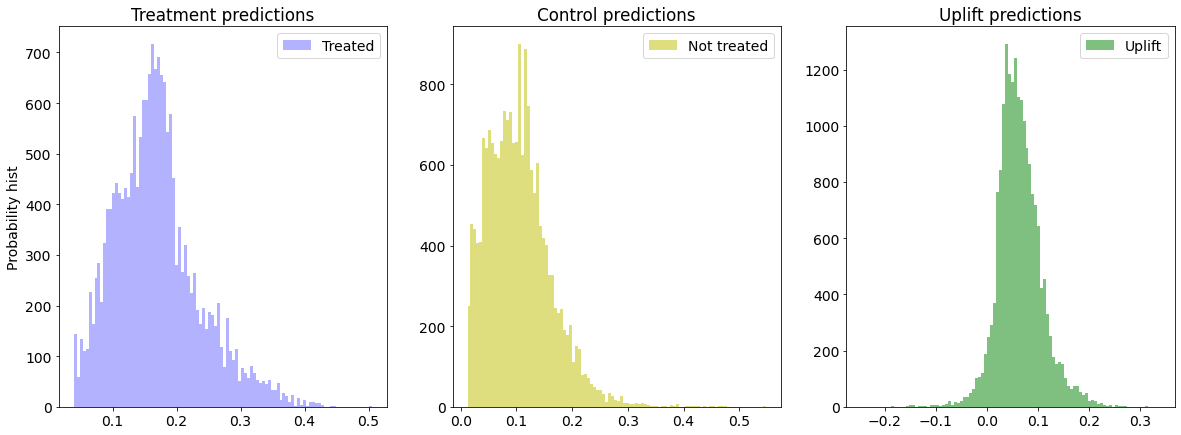

In [23]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)

tm = tm.fit(X_train, y_train, treat_train)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)


models_results['name'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [24]:
pd.DataFrame(data=models_results).sort_values('uplift@20%', ascending=False)

name  uplift@10%  uplift@20%
1  ClassTransformation     0.24449     0.20141
2            TwoModels     0.05988     0.07351
0            SoloModel     0.07630     0.06061

### UpliftTreeClassifier

In [25]:
X_train_tree = X_train
features = [col for col in X_train_tree]

In [26]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)

CPU times: user 11.1 s, sys: 660 ms, total: 11.8 s
Wall time: 16.9 s


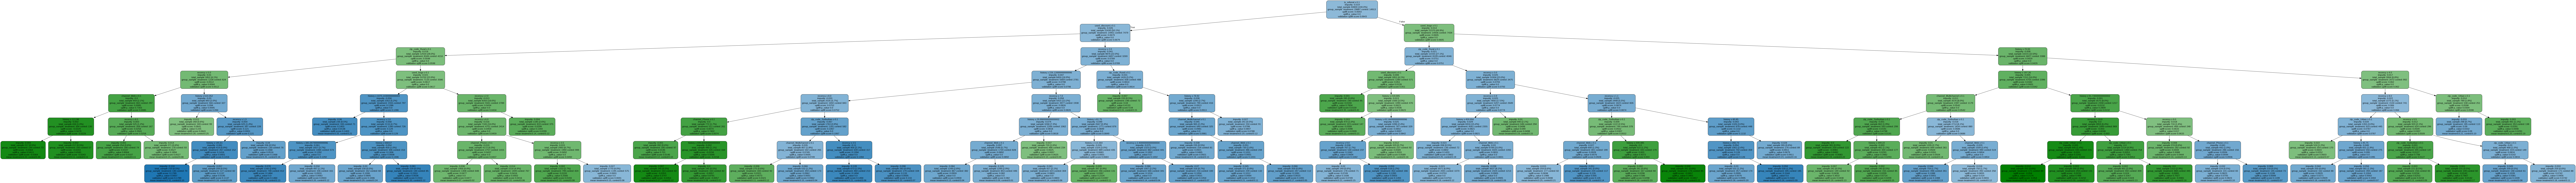

In [27]:
Image(graph.create_png())

Для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift:

1) сделать прогноз и получить uplift для тестовой выборки

2) отсортировать тестовую выборку по uplift по убыванию

3) разбить на децили (pandas qcut вам в помощь)

4) для каждого дециля посчитать среднюю conversion

In [28]:
X_test_uplift = X_test
X_test_uplift['uplift'] = uplift_sm
X_test_uplift['conversion'] = y_test

In [29]:
X_test_uplift = X_test_uplift.sort_values(['uplift'], ascending=False)
X_test_uplift.head()

recency    history  used_discount  used_bogo  is_referral  treatment  \
22367       12 1071.42000              1          1            1          1   
19608       12  890.77000              1          1            1          1   
55253       12  717.00000              1          1            1          0   
39823       12  882.78000              1          1            1          1   
62669       12  893.17000              1          1            1          0   

       zip_code_Rural  zip_code_Surburban  zip_code_Urban  \
22367               0                   0               1   
19608               0                   1               0   
55253               0                   1               0   
39823               0                   1               0   
62669               0                   0               1   

       channel_Multichannel  channel_Phone  channel_Web  uplift  conversion  
22367                     1              0            0 0.24869           0  
19608                     1              0            0 0.22759           1  
55253                     1              0            0 0.22759           0  
39823                     1              0            0 0.22759           0  
62669                     1              0            0 0.19967           0

In [30]:
X_test_uplift['qcut']=pd.qcut(X_test_uplift['uplift'], 4, labels=False)

In [31]:
X_test_uplift

recency    history  used_discount  used_bogo  is_referral  treatment  \
22367       12 1071.42000              1          1            1          1   
19608       12  890.77000              1          1            1          1   
55253       12  717.00000              1          1            1          0   
39823       12  882.78000              1          1            1          1   
62669       12  893.17000              1          1            1          0   
...        ...        ...            ...        ...          ...        ...   
44849       10  742.80000              1          1            1          1   
49421       10  883.63000              1          1            1          1   
47650        9  702.49000              1          1            1          0   
13080       10  657.80000              1          1            1          1   
51095        9  679.01000              1          1            1          1   

       zip_code_Rural  zip_code_Surburban  zip_code_Urban  \
22367               0                   0               1   
19608               0                   1               0   
55253               0                   1               0   
39823               0                   1               0   
62669               0                   0               1   
...               ...                 ...             ...   
44849               1                   0               0   
49421               1                   0               0   
47650               1                   0               0   
13080               1                   0               0   
51095               1                   0               0   

       channel_Multichannel  channel_Phone  channel_Web   uplift  conversion  \
22367                     1              0            0  0.24869           0   
19608                     1              0            0  0.22759           1   
55253                     1              0            0  0.22759           0   
39823                     1              0            0  0.22759           0   
62669                     1              0            0  0.19967           0   
...                     ...            ...          ...      ...         ...   
44849                     0              1            0 -0.03356           0   
49421                     1              0            0 -0.03841           1   
47650                     0              0            1 -0.03991           0   
13080                     0              0            1 -0.04214           0   
51095                     0              0            1 -0.04252           0   

       qcut  
22367     3  
19608     3  
55253     3  
39823     3  
62669     3  
...     ...  
44849     0  
49421     0  
47650     0  
13080     0  
51095     0  

[19200 rows x 15 columns]

In [33]:
X_test_uplift_сat = X_test_uplift[X_test_uplift['qcut'] == 0]
X_test_uplift_сat['conversion'].mean()

0.10306058713304185

In [34]:
X_test_uplift_сat = X_test_uplift[X_test_uplift['qcut'] == 1]
X_test_uplift_сat['conversion'].mean()

0.12367270455965022

In [35]:
X_test_uplift_сat = X_test_uplift[X_test_uplift['qcut'] == 2]
X_test_uplift_сat['conversion'].mean()

0.16082603254067585

In [36]:
X_test_uplift_сat = X_test_uplift[X_test_uplift['qcut'] == 3]
X_test_uplift_сat['conversion'].mean()

0.18791666666666668

### UpliftRandomForestClassifier

In [37]:
%%time
uplift_rfc = UpliftRandomForestClassifier(control_name='control', max_depth=8)

uplift_rfc.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment', 0: 'control'}).values,
                 y=y_train.values)

CPU times: user 125 ms, sys: 53.9 ms, total: 179 ms
Wall time: 24 s


In [38]:
graph_rfc = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)

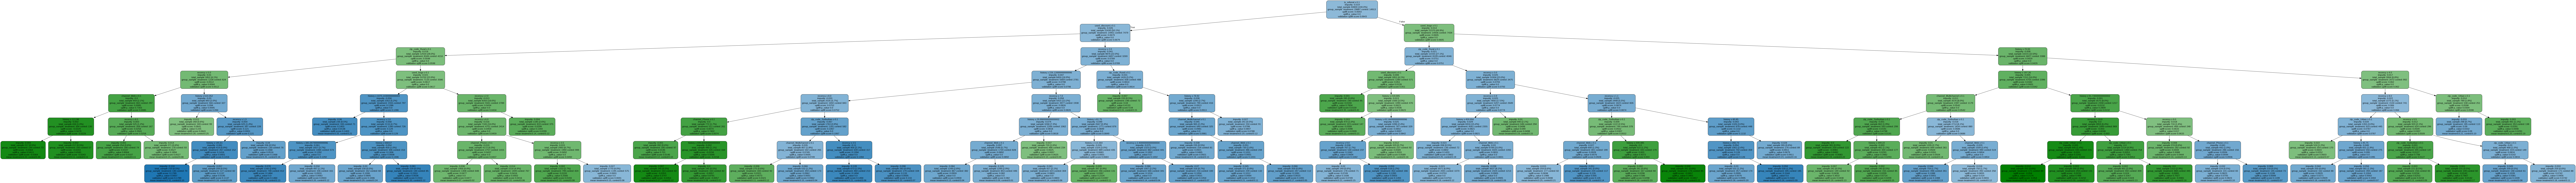

In [39]:
Image(graph_rfc.create_png())